In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2467, 3)
(91883, 7)


In [5]:
ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/np.median(dists))    # normalize flux by heliocentric distance
us = results[:,4] * (dists/np.median(dists))    # normalize flux uncertainty by heliocentric distance
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [6]:
print("171")
print(np.shape(fs[m171]))
print(np.shape(fs[m171 & noPinholes])[0]/np.shape(fs[m171])[0])
print(np.shape(fs[m171 & noPinholes & noCameraErrors])[0]/np.shape(fs[m171])[0])

print("195")
print(np.shape(fs[m195]))
print(np.shape(fs[m195 & noPinholes])[0]/np.shape(fs[m195])[0])
print(np.shape(fs[m195 & noPinholes & noCameraErrors])[0]/np.shape(fs[m195])[0])

print("284")
print(np.shape(fs[m284]))
print(np.shape(fs[m284 & noPinholes])[0]/np.shape(fs[m284])[0])
print(np.shape(fs[m284 & noPinholes & noCameraErrors])[0]/np.shape(fs[m284])[0])

print("304")
print(np.shape(fs[m304]))
print(np.shape(fs[m304 & noPinholes])[0]/np.shape(fs[m304])[0])
print(np.shape(fs[m304 & noPinholes & noCameraErrors])[0]/np.shape(fs[m304])[0])

171
(22735,)
0.9996481196393227
0.5035847811744008
195
(23507,)
0.9953630833368784
0.5048283490024248
284
(22845,)
0.9440140074414533
0.4671481724666229
304
(22796,)
0.9955693981400245
0.49328829619231446


In [7]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
heaterOn 1998/04/10    22:00   72.0 2450914.417
     ...        ...      ...    ...         ...
heaterOn  2012/01/5    21:00  145.0 2455932.375
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456

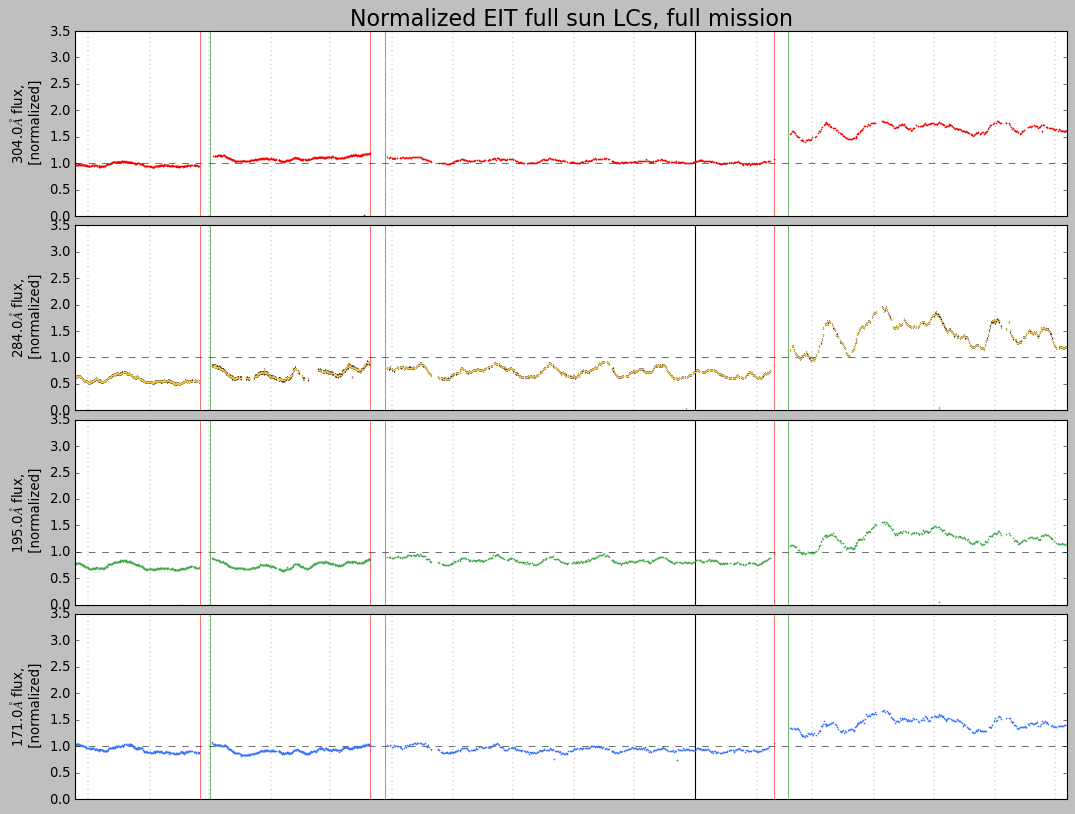

In [58]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(16,12))


for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    #axes[3].text(jan1_thisyear + 180., 0.1, str(y),horizontalalignment='center',fontsize=10)

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)
    ax.axhline(1, color='k', ls = '--', lw=0.5, zorder=1)

    
for i, ax in enumerate(axes):
    wmask = wmasks[i] #& noPinholes #& noCameraErrors

    fluxnorm = np.median(fs[wmasks[i]][~np.isnan(fs[wmasks[i]])])

    plotcolor = cs[i]
    
    axes[i].errorbar(ts[wmask], fs[wmask]/fluxnorm, yerr=us[wmask]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor='k')
    #axes[i].plot(ts[wmask], 0.3*np.ones_like(ts[wmask]), marker='|',ms=20,mec=plotcolor,ls='None')
    #axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" [normalized]".format(ws[wmask][0]))

for ax in axes:
    ax.set_xticks([])

    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,3.5)
    #ax.set_xlim(2450000, 2460750)
    ax.set_xlim(2455250,2455750)

    
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    
axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)
plt.subplots_adjust(hspace=0.05)
plt.show()
#plt.savefig("./EIT_LCs_fullmission.pdf", bbox_inches="tight")

# Evaluate whether the ratio of (first flux after bakeout)/(last flux before bakeout) is the same across the four bands.

In [23]:
b171 = np.zeros(80,dtype=int)
a171 = np.zeros(80,dtype=int)

b195 = np.zeros(80,dtype=int)
a195 = np.zeros(80,dtype=int)

b284 = np.zeros(80,dtype=int)
a284 = np.zeros(80,dtype=int)

b304 = np.zeros(80,dtype=int)
a304 = np.zeros(80,dtype=int)

bs = [b171, b195, b284, b304]
afs = [a171, a195, a284, a304]

for i in range(4):
    wmask = wmasks[i] & noPinholes #& noCameraErrors

    for j in range(80):
        bakeoutStart = heaterOn[j]['jd']
        bakeoutEnd = heaterOff[j]['jd']

        beforeBakeoutMask = (ts[wmask] < bakeoutStart)
        afterBakeoutMask = (ts[wmask] > bakeoutEnd)

        bs[i][j] = int(np.arange(len(ts[wmask]))[beforeBakeoutMask][-1])
        afs[i][j]= int(np.arange(len(ts[wmask]))[afterBakeoutMask][0])
        

In [40]:
#flux ratios

fr171 = np.zeros(80)
fr195 = np.zeros(80)
fr284 = np.zeros(80)
fr304 = np.zeros(80)

frs = [fr171, fr195, fr284, fr304]

for i in range(4):
    wmask = wmasks[i]
    for j in range(80):
        frs[i][j] = fs[wmask][afs[i][j]]/fs[wmask][bs[i][j]]

In [52]:
print(np.max(fr304))

2.117088643681295


In [41]:
# array of 80 random flux ratios for comparison
random_fr171 = np.zeros(80)
random_fr195 = np.zeros(80)
random_fr284 = np.zeros(80)
random_fr304 = np.zeros(80)

random_frs = [random_fr171, random_fr195, random_fr284, random_fr304]

for i in range(4):
    wmask = wmasks[i]
    for j in range(80):
        random_frs[i][j] = fs[wmask][np.random.randint(low=0,high=len(fs[wmask]))]/fs[wmask][np.random.randint(low=0,high=len(fs[wmask]))]

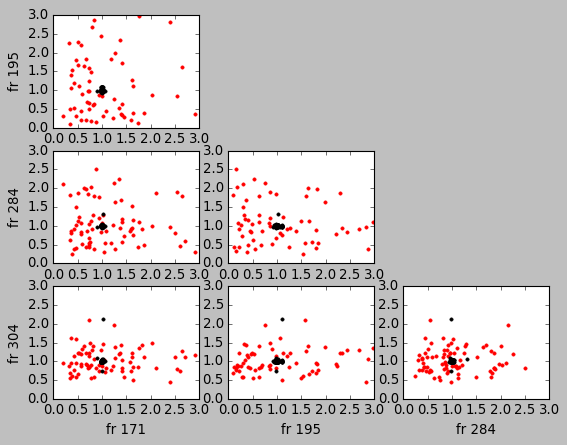

In [48]:
fig, axes = plt.subplots(3,3)

axes[0,0].plot(random_fr171,random_fr195,'r.',zorder=1)
axes[1,0].plot(random_fr171,random_fr284,'r.',zorder=1)
axes[2,0].plot(random_fr171,random_fr304,'r.',zorder=1)

axes[1,1].plot(random_fr195,random_fr284,'r.',zorder=1)
axes[2,1].plot(random_fr195,random_fr304,'r.',zorder=1)

axes[2,2].plot(random_fr284,random_fr304,'r.',zorder=1)

axes[0,0].plot(fr171,fr195,'k.',zorder=2)
axes[1,0].plot(fr171,fr284,'k.',zorder=2)
axes[2,0].plot(fr171,fr304,'k.',zorder=2)

axes[1,1].plot(fr195,fr284,'k.',zorder=2)
axes[2,1].plot(fr195,fr304,'k.',zorder=2)

axes[2,2].plot(fr284,fr304,'k.',zorder=2)

axes[2,0].set_xlabel("fr 171")
axes[0,0].set_ylabel("fr 195")

axes[1,0].set_ylabel("fr 284")
axes[2,0].set_ylabel("fr 304")

axes[2,1].set_xlabel("fr 195")
axes[2,2].set_xlabel("fr 284")

for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in np.ravel(axes):
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

plt.show()

# Look at using the CELIAS-SEM narrow-band light curve to stitch together the discontinuities in the EIT 304\AA band LC

In [129]:
# load the version that's already normalized by heliocentric distance
SEM = np.genfromtxt("./CELIAS-SEM/SEMDailyData_norm.txt")

# columns:
# [:,0] = t_obs[JD]
# [:,1] = firstOrderFlux[counts/s]      #narrow-band (24-34 nm)
# [:,2] = firstOrderFluxUnc[counts/s]
# [:,3] = centralOrderFlux[counts/s]    #broad-band (0.1-50 nm)
# [:,4] = centralOrderFluxUnc[counts/s]

SEMmed = np.median(SEM[:,1][~np.isnan(SEM[:,1])])

In [130]:
print(SEM[:,0])

[2450073. 2450074. 2450075. ... 2460347. 2460348. 2460349.]


In [131]:
# bin 304\AA light curve into days, for easier comparison
fluxnorm_171 = np.median(fs[m171][~np.isnan(fs[m171])])
fluxnorm_195 = np.median(fs[m195][~np.isnan(fs[m195])])
fluxnorm_284 = np.median(fs[m284][~np.isnan(fs[m284])])
fluxnorm_304 = np.median(fs[m304][~np.isnan(fs[m304])])

binned_EIT_171, bin_edges, binnumber = binned_statistic(ts[m171], fs[m171]/fluxnorm_171, statistic='median', bins=np.arange(2450072,2460350)+0.5)
binned_EIT_195, bin_edges, binnumber = binned_statistic(ts[m195], fs[m195]/fluxnorm_195, statistic='median', bins=np.arange(2450072,2460350)+0.5)
binned_EIT_284, bin_edges, binnumber = binned_statistic(ts[m284], fs[m284]/fluxnorm_284, statistic='median', bins=np.arange(2450072,2460350)+0.5)
binned_EIT_304, bin_edges, binnumber = binned_statistic(ts[m304], fs[m304]/fluxnorm_304, statistic='median', bins=np.arange(2450072,2460350)+0.5)


In [132]:
print(len(binned_EIT_304))
print(len(SEM[:,0]))

10277
10277


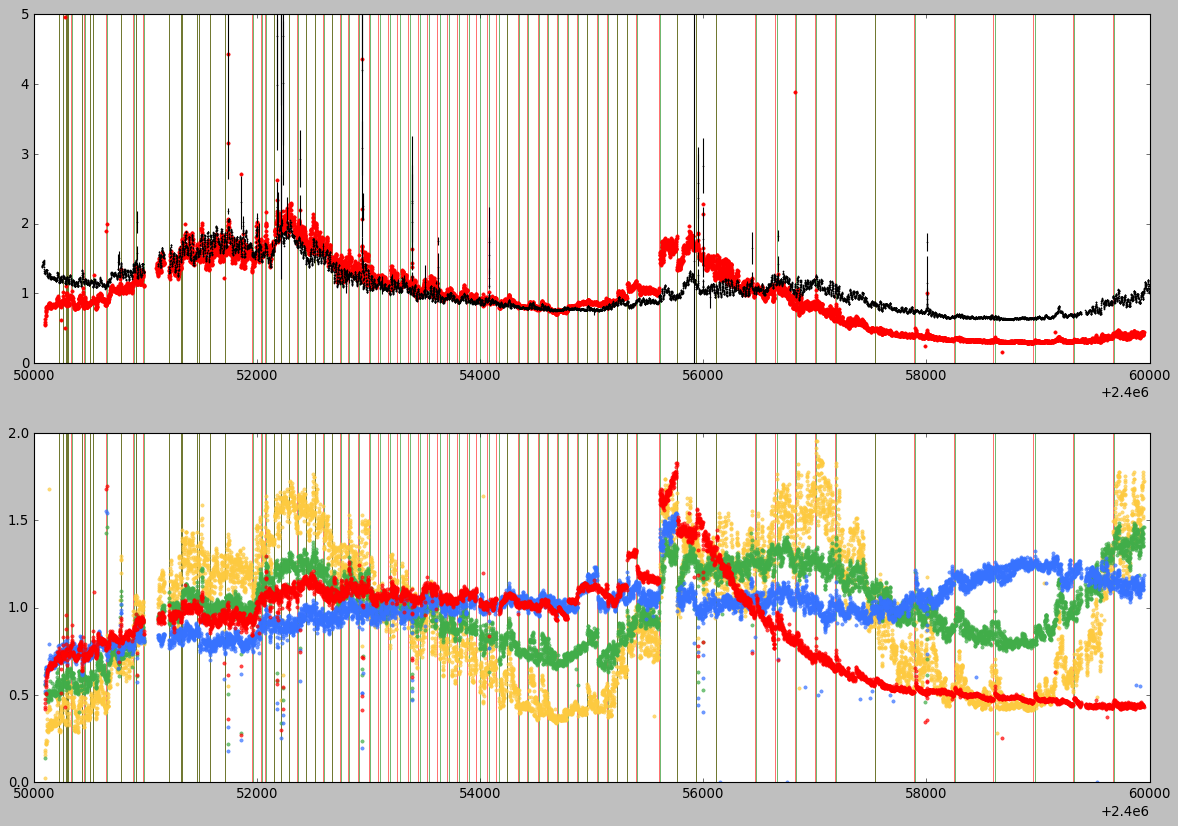

In [133]:
fig, axes = plt.subplots(2,1,figsize=(18,12))

for i in range(80):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    for ax in axes:
        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)


#axes[0].errorbar(ts[m304], fs[m304]/fluxnorm, yerr=us[m304]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c='r',ecolor='k')
axes[0].plot(np.arange(2450073,2460350), binned_EIT_304, 'r.')
axes[0].errorbar(SEM[:,0], SEM[:,1]/SEMmed, yerr=SEM[:,2]/SEMmed, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c='k',ecolor='k')
axes[0].set_ylim(0.,5)


axes[1].plot(SEM[:,0],binned_EIT_304/(SEM[:,1]/SEMmed), marker='.',color="r",ls='None',alpha=0.7,zorder=4)
axes[1].plot(SEM[:,0],binned_EIT_284/(SEM[:,1]/SEMmed), marker='.',color="#fdca40",ls='None',alpha=0.7)
axes[1].plot(SEM[:,0],binned_EIT_195/(SEM[:,1]/SEMmed), marker='.',color="#41ad49",ls='None',alpha=0.7)
axes[1].plot(SEM[:,0],binned_EIT_171/(SEM[:,1]/SEMmed), marker='.',color="#3772ff",ls='None',alpha=0.7)
axes[1].set_ylim(0,2)

for ax in axes:
    ax.set_xlim(2450000, 2460000)
    #ax.set_xlim(2455250, 2456000)
plt.show()
    

# try same exercise with VIRGO TSI


In [134]:
virgo = np.genfromtxt("./VIRGO/virgoDailyData.txt")

#columns:
# [:,0] = t_obs [JD]
# [:,1] = flux [W/m^2]
# [:,2] = flux_unc [W/m^2]

In [135]:
print(virgo[:,1])
virgomed = np.median(virgo[:,1][~np.isnan(virgo[:,1])])

[1360.481 1360.406 1360.412 ... 1361.805 1361.762 1361.749]


In [136]:
binned_EIT_171, bin_edges, binnumber = binned_statistic(ts[m171], fs[m171]/fluxnorm_171, statistic='median', bins=np.arange(2450134,2460264)+0.5)
binned_EIT_195, bin_edges, binnumber = binned_statistic(ts[m195], fs[m195]/fluxnorm_195, statistic='median', bins=np.arange(2450134,2460264)+0.5)
binned_EIT_284, bin_edges, binnumber = binned_statistic(ts[m284], fs[m284]/fluxnorm_284, statistic='median', bins=np.arange(2450134,2460264)+0.5)
binned_EIT_304, bin_edges, binnumber = binned_statistic(ts[m304], fs[m304]/fluxnorm_304, statistic='median', bins=np.arange(2450134,2460264)+0.5)


In [137]:
print(len(binned_EIT_284))
print(len(virgo[:,0]))

10129
10129


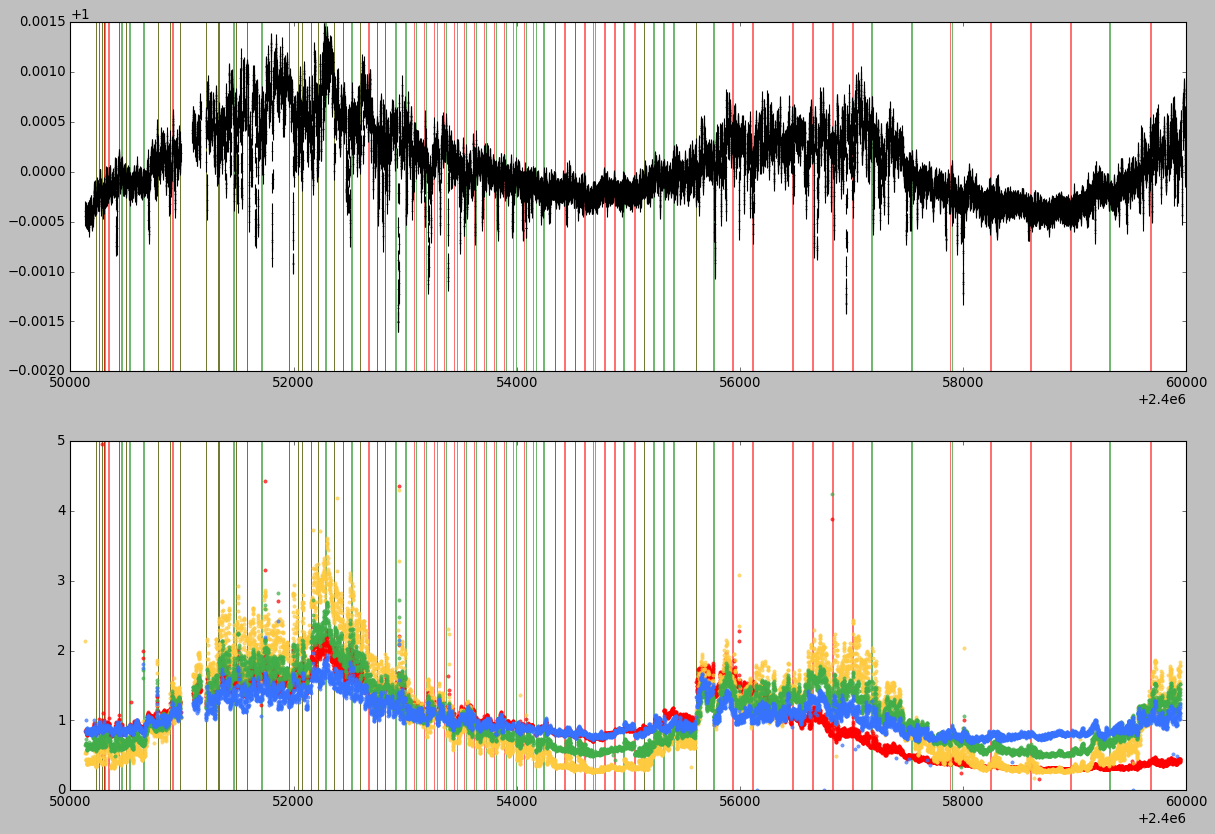

In [138]:
fig, axes = plt.subplots(2,1,figsize=(18,12))

for i in range(80):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    for ax in axes:
        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)


#axes[0].errorbar(ts[m304], fs[m304]/fluxnorm, yerr=us[m304]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c='r',ecolor='k')
#axes[0].plot(np.arange(2450134,2460263), binned_EIT_304, 'r.')
axes[0].errorbar(virgo[:,0], virgo[:,1]/virgomed, yerr=virgo[:,2]/virgomed, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c='k',ecolor='k')
#axes[0].set_ylim(0.,5)


axes[1].plot(virgo[:,0],binned_EIT_304/(virgo[:,1]/virgomed), marker='.',color="r",ls='None',alpha=0.7)
axes[1].plot(virgo[:,0],binned_EIT_284/(virgo[:,1]/virgomed), marker='.',color="#fdca40",ls='None',alpha=0.7)
axes[1].plot(virgo[:,0],binned_EIT_195/(virgo[:,1]/virgomed), marker='.',color="#41ad49",ls='None',alpha=0.7)
axes[1].plot(virgo[:,0],binned_EIT_171/(virgo[:,1]/virgomed), marker='.',color="#3772ff",ls='None',alpha=0.7)
axes[1].set_ylim(0,5)

for ax in axes:
    ax.set_xlim(2450000, 2460000)
    #ax.set_xlim(2455250, 2456000)
plt.show()
    